# MNIST

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [126]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [127]:
#  lets look at the arrays
X,y = mnist['data'], mnist['target']
print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Columns: 784 entries, pixel1 to pixel784
dtypes: float64(784)
memory usage: 418.7 MB
None
<class 'pandas.core.series.Series'>
RangeIndex: 70000 entries, 0 to 69999
Series name: class
Non-Null Count  Dtype   
--------------  -----   
70000 non-null  category
dtypes: category(1)
memory usage: 68.9 KB
None


In [128]:
# convert pandas df to np array
X_np = X.to_numpy()

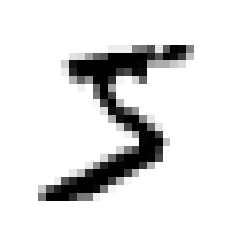

In [129]:
# 70000 images and 784 features, each image is 28 x 28 pixels, and each feature is a pixels intensity from 0 (white) to 255 (black)

# to view an image:
some_digit = X_np[0] # grab instances feature vector

some_digit_image = some_digit.reshape(28,28)

plt.imshow(some_digit_image, cmap='binary')
plt.axis('off')
plt.show()

In [130]:
# image label:
y[0]

'5'

In [131]:
# cast string labels to integers:
y = y.astype(np.uint8)

In [132]:
# create test set:
X_train, X_test, y_train, y_test = X_np[:60000], X_np[60000:], y[:60000], y[60000:]

# Training a  Binary Classifier

In [133]:
# For now only try to identify one number, ie: a "5-detector", able to distinguish between 2 classes, 5 and non-5

# create target vectors
y_train_5 = (y_train == 5) # True for all 5's, False for all other digits
y_test_5 = (y_test == 5)

In [134]:
# Stochastic Gradient Descent Classifier (handles large datasets efficiently, independantly training one instance at a time)
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(random_state=42)

In [135]:
sgd_clf.predict([some_digit])

array([ True])

The Classifier guesses this image represents a 5 (True). Looks like it got it right in this case but lets evaluate the models performance

# Performance Measures

**Measuring Accuracy Using Cross-Validation**

In [136]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [137]:
# create dumb classifier (classifies every image as "not-5") to compare above results
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [138]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

The dumb classifier achieves over 90% accuracy! This is because only 10% of images are 5's (so if you always guess an image as not a 5, you will be right 90% of the time!)

This demonstrates why accuracy is not the preferred measure for classifiers, espeacilly with a skewed dataset

**Confusion Matrix**

In [139]:
# to compute the cfm you need a set of predictions to compare to actual targets
# can use test set but better to use cross_val_predict()
# performs k-fold cross-validation and returns predictions made on each test fold

from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [140]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- each row is an actual class, each column is a predicted class
- first row is negative class, second row is positive class
- precision = accuracy of positive predictions
- recall = positive instances detected by classifier

**Precision and Recall**

In [141]:
from sklearn.metrics import precision_score

# compute precision
precision_score(y_train_5, y_train_pred) # == 3530 / (3530 + 687)

0.8370879772350012

when it claims an image represents a 5, it is only correct 83% of the time

In [142]:
# compute recall
from sklearn.metrics import recall_score
recall_score(y_train_5, y_train_pred) # == 3530 / (3530 + 1891)

0.6511713705958311

only detects 65% of 5's

In [143]:
# compute F1 score
# high f1_score if both precision and recall high, harmonic mean
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)


0.7325171197343846

**Precision/Recall Trade-off**

In [144]:
# increasing threshold decreases recall and increases precision
# decreasing threshold increases recall and decreases precision

# get decision score used to make predictions
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)
# set threshold
threshold = 0
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


SGD use threshold = 0 as default so previous code returns same result as predict() method

In [145]:
# increase threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
print(y_some_digit_pred)

[False]


raising threshold reduces recall. image is a 5, classifier detects it at threshold 0 but misses it at 8000

In [146]:
# How to decide which threshold to use?

# use cross_val_predict() to get decision scores
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [147]:
# use precision_recall_curve() to compute precision and recall for all possible thresholds
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [148]:
precisions.shape

(59967,)

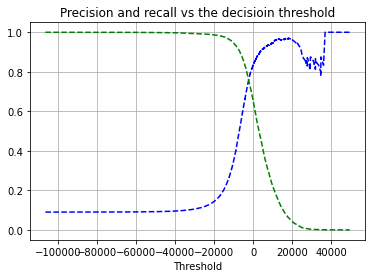

In [149]:
# use matplotlib to plot precision and recall as a function of the threshold value
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.title("Precision and recall vs the decisioin threshold")
    plt.xlabel('Threshold')
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="Recall")
    plt.grid()


plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

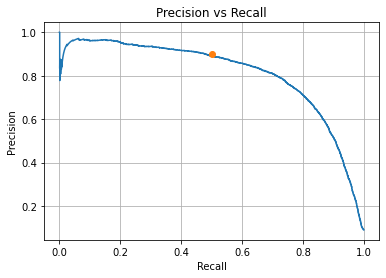

In [150]:
def plot_precision_vs_recall(recalls, precisions):
    plt.title("Precision vs Recall")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.plot(recalls, precisions)
    plt.plot(0.5,0.9, "o")
    plt.grid()


plot_precision_vs_recall(recalls, precisions)
plt.show()


In [151]:
# decide to aim for 90% precision

threshold_90_precision = thresholds[np.argmax(precisions >=0.90)]  # 3370.0194991439557, lowest threshold that gives 90% precision

In [152]:
# to make predictions, instead of predict() method, run this code
y_train_pred_90 = (y_scores >=threshold_90_precision)

In [153]:
print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


As you can see its easy to create a classifier with any precision you want, just set a high enough threshold!

But a high precision classifier is not very useful if recall is low

**The ROC Curve**

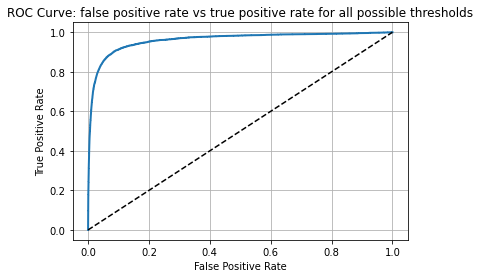

In [164]:
# receiver operating characteristic
# plots TPR vs FPR (sensitivity(recall) vs 1 - specificty(TNR))

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    
    plt.xlabel("False Positive Rate")
    plt.ylabel('True Positive Rate')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--') #dashed diagonal
    plt.grid()


plot_roc_curve(fpr, tpr)
plt.title("ROC Curve: false positive rate vs true positive rate for all possible thresholds")
plt.show()


In [160]:
# Area Under Curve (AUC) used to compare classifiers (perfect classifier ROC AUC = 1, random classifier ROC AUC = 0.5)

from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since ROC cure and precision/recall(PR) similar, which one to use?
- prefer PR curve when positive class is rare or you care more about false positives than false negatives
- otherwise, use ROC curve (and the ROC AUC score)

In [161]:
# in this case ROC AUC looks great (fewer positives(5's) compared with negatives(non-5's))but PR shows classifier has room for improvement(curve should be closer to top right corner)

In [179]:
# now lets train a RandomForestClassifier and compare its ROC curve and ROC AUC score to the SGDClassifier

# RandomForestClassifier has predict_proba() instead of decision_function() seen in SGDClassifier, returns array with a row per instance and column per class each containing probability given instance belongs to a given class
# scikit learn classifiers have either or both
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [180]:
y_proba_scores_forest = y_probas_forest[:,1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_proba_scores_forest)

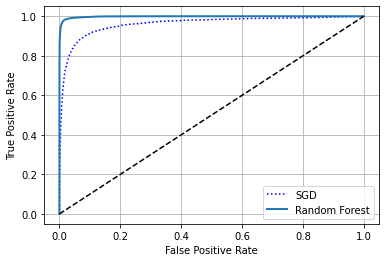

In [181]:
# plot ROC curve with first ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [182]:
# calculate ROC AUC score
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

- RandomForestClassifier ROC curve looks much better than the SGDClassifiers (it comes to the top left corner). 
- ROC AUC score is signifcantly better

In [183]:
# measuring precision and recall scores
y_scores_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

print(precision_score(y_train_5, y_scores_forest))
print(recall_score(y_train_5, y_scores_forest))


0.9905083315756169
0.8662608374838591


model precision and recall much better

you now know how to:
- train binary classifier
- choose appropriate metric for your task
- evaluate your classifiers using cross-validation
- select the precision/recall tradeoff that fits your needs
- use roc curves and ROC AUC to compare models

# Multiclass Classification

In [ ]:
# some algorithms strictly binary classifiers(SGD, SVC)
# strategies to deal with multiclass classification with multiple binary classifiers
# OneVersusRest and OneVersusOne